In [2]:
# importeren van alle belangerijke modules
import pandas as pd
import numpy as np
import re
from dataclasses import dataclass
from pathlib import Path
from typing import List, Optional, Tuple, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize

#display-instellingen
pd.set_option("display.max_colwidth", 200)

# maakt de kolomnamen klein en snake_case
def norm_col(name: str) -> str:
    name = str(name).strip().lower()
    name = re.sub(r"\s+", "_", name)
    name = name.replace("-", "_")
    return name


In [3]:
# csv bestand openen
csv_path = 'Uitgebreide_VKM_dataset.csv'\
# dataset defenieren
VKMDataWithoutNew = pd.read_csv(csv_path, sep=None, engine='python')
# Hij gaat hier door de lijst om de functie norm_col aan te roepen
# norm_col zorgt ervoor dat het klein en snake_case wordt
VKMDataWithoutNew.columns = [norm_col(c) for c in VKMDataWithoutNew.columns]
# geeft aantal rijen en kolommen aan
print("Vorm van de data:", VKMDataWithoutNew.shape)
# laat de eerste 5 rijen zien
display(VKMDataWithoutNew.head())
# laat de kolom informatie zien
print("\nKolominformatie:")
print(VKMDataWithoutNew.info())
# missende waarde per kolom
print("\nAantal missende waarden per kolom:")
print(VKMDataWithoutNew.isna().sum())


Vorm van de data: (211, 20)


,id,name,shortdescription,description,content,studycredit,location,contact_id,level,learningoutcomes,rood,groen,blauw,geel,module_tags,interests_match_score,popularity_score,estimated_difficulty,available_spots,start_date
0,159,Kennismaking met Psychologie,"Brein, gedragsbeinvloeding, ontwikkelingspsychologie, gespreksvoering en ontwikkelingsfasen.",In deze module leer je hoe je gedrag van jezelf en van anderen kunt begrijpen en beinvloeden. Je maakt kennis met de basistheorie van Psychologie. Aan bod komen onderwerpen die te maken hebben met...,In deze module leer je hoe je gedrag van jezelf en van anderen kunt begrijpen en beinvloeden. Je maakt kennis met de basistheorie van Psychologie. Aan bod komen onderwerpen die te maken hebben met...,15,Den Bosch,58,NLQF5,A. Je beantwoordt vragen in een meerkeuze kennistoets waarin je laat zien dat je de basis van de psychologie kunt reproduceren en begrijpt. Je laat zien dat je gedrag van individuen en groepen in ...,4.0,2.0,1.0,5.0,"['brein', 'gedragsbeinvloeding', 'ontwikkelingspsychologie', 'gespreksvoering', 'en', 'ontwikkelingsfasen']",0.54,319,1,79,2025-12-24
1,160,Learning and working abroad,"Internationaal, persoonlijke ontwikkeling, verpleegkunde","Studenten kiezen binnen de (stam) van de opleiding van Verpleegkunde steeds vaker voor een stage in het buitenland, waarbij zij de beroepsprestaties graag in een internationale stagecontext willen...","Studenten kiezen binnen de (stam) van de opleiding van Verpleegkunde steeds vaker voor een stage in het buitenland, waarbij zij de beroepsprestaties graag in een internationale stagecontext willen...",15,Den Bosch,58,NLQF5,De student toont professioneel gedrag conform de beroepscode bij laagcomplexe zorgvragers en collega's in de zorgsetting.,5.0,3.0,1.0,1.0,"['internationaal', 'persoonlijke', 'ontwikkeling', 'verpleegkunde']",0.92,172,5,56,2025-12-20
2,161,Proactieve zorgplanning,"Proactieve zorgplanning, cocreatie, ziekenhuis","Het Jeroen Bosch ziekenhuis wil graag samen met de opleiding Verpleegkunde een module ontwikkelen, waarin de studenten de mogelijkheid krijgen om zich te verdiepen in de ziekenhuissetting. JBZ sta...","Het Jeroen Bosch ziekenhuis wil graag samen met de opleiding Verpleegkunde een module ontwikkelen, waarin de studenten de mogelijkheid krijgen om zich te verdiepen in de ziekenhuissetting. JBZ sta...",15,Den Bosch,59,NLQF5,"De student past pro actieve zorgplanning toe binnen het proces van het klinisch redeneren bij casuïstiek over zorgvragers, multidisciplinair, in de ziekenhuissetting.",NaN,NaN,NaN,NaN,"['proactieve', 'zorgplanning', 'cocreatie', 'ziekenhuis']",0.78,217,5,55,2025-09-23
3,162,Rouw en verlies,"Rouw & verlies, palliatieve zorg & redeneren, trauma, culturele diversiteit","In deze module wordt stil gestaan bij rouw en verlies, vanuit diverse invalshoeken waaronder de palliatieve zorg. Thema's zoals oncologie kunnen hier een plaats krijgen (werkveld verpleegkunde vra...","In deze module wordt stil gestaan bij rouw en verlies, vanuit diverse invalshoeken waaronder de palliatieve zorg. Thema's zoals oncologie kunnen hier een plaats krijgen (werkveld verpleegkunde vra...",30,Den Bosch,58,NLQF6,De student regisseert en voert (deels) zelfstandig en in samenwerkingsverband het palliatieve proces uit bij hoog/middencomplexe zorgvragers in de zorgsetting op basis van het proces van palliatie...,NaN,NaN,NaN,NaN,"['rouw', 'verlies', 'palliatieve', 'zorg', 'redeneren', 'trauma', 'culturele', 'diversiteit']",0.69,454,1,54,2025-10-25
4,163,Acuut complexe zorg,"Acute zorg, complexiteit, ziekenhuis, revalidatie","In deze module kunnen studenten zich verdiepen in de acuut, complexe zorg binnen het verpleegkundig vakgebied.","In deze module kunnen studenten zich verdiepen in de acuut, complexe zorg binnen het verpleegkundig vakgebied.",30,Den Bosch,58,NLQF6,De student regisseert en voert (deels) zelfstandig en in samenwerkingsverband het verpleegkundige proces uit bij hoog/middencomplexe zorgvragers in de actue en


Kolominformatie:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     211 non-null    int64  
 1   name                   211 non-null    object 
 2   shortdescription       191 non-null    object 
 3   description            211 non-null    object 
 4   content                211 non-null    object 
 5   studycredit            211 non-null    int64  
 6   location               211 non-null    object 
 7   contact_id             211 non-null    int64  
 8   level                  211 non-null    object 
 9   learningoutcomes       206 non-null    object 
 10  rood                   2 non-null      float64
 11  groen                  2 non-null      float64
 12  blauw                  2 non-null      float64
 13  geel                   2 non-null      float64
 14  module_tags            211 non-null    o

<Axes: ylabel='Frequency'>

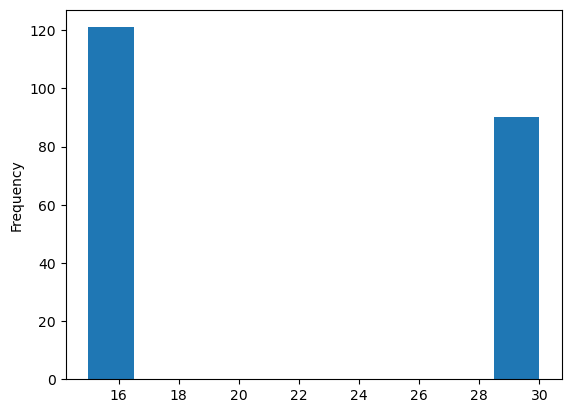

In [4]:
VKMDataWithoutNew['studycredit'].plot(kind='hist')

Findings: Alle waarden zijn of 15 of 30. Dat is zoals het hoort en er zijn dus geen verkeerde waarden. Je ziet wel dat er redelijk wat modules meer zijn die 15 studiepunten zijn dan dat er modules zijn die 30 studiepunten zijn.

<Axes: ylabel='Frequency'>

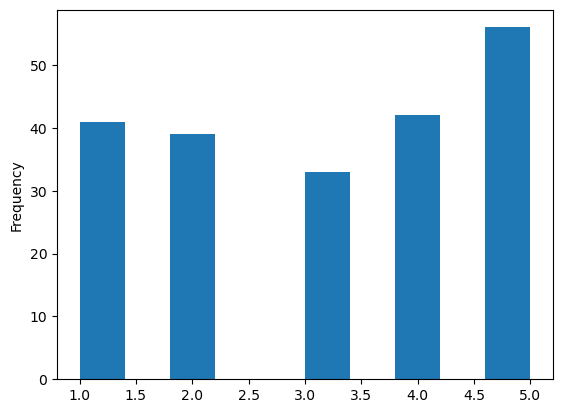

In [5]:
VKMDataWithoutNew['estimated_difficulty'].plot(kind='hist')

Findings: De estimated difficulty is een heel getal tussen de 1 en de 5. Alle waarden zijn ook 1, 2, 3, 4 of 5. Er zijn dus geen verkeerde waarden. Je kan ook zien dat een estimated difficulty van 5 het meest voorkomt. Het gemiddelde niveau van de modules is dus best hoog.

<Axes: >

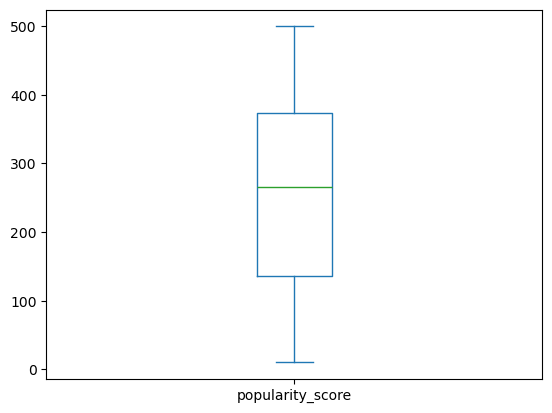

In [6]:
VKMDataWithoutNew['popularity_score'].plot(kind='box')

Findings: In de boxplot zie je geen outliers. Er zijn dus geen modules die veel populairder of veel minder populair zijn dan andere modules. Ook zie je dat alle vakken van de boxplot bijna even groot zijn. Dit betekent dat alle kwartiel ongeveer gelijk is, wat duidt op een symmetrische verdeling.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joasd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joasd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joasd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\joasd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


<Axes: >

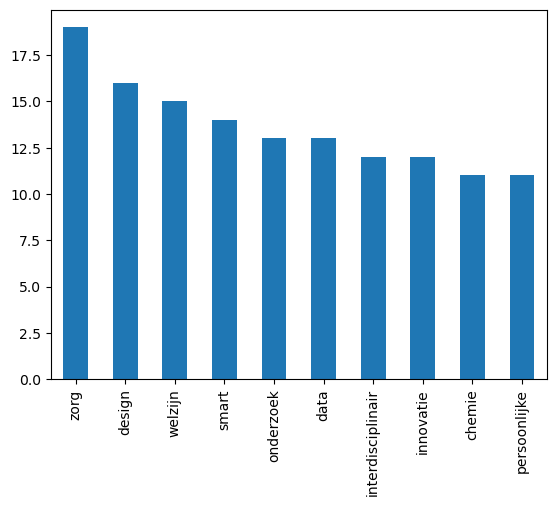

In [7]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

all_shortdescriptions = VKMDataWithoutNew['shortdescription']

# Alles naar lowercase
all_shortdescr_lowered = all_shortdescriptions.str.lower()

# Cijfers verwijderen
all_shortdescr_low_nonmbr = all_shortdescr_lowered.str.replace(r'\d+', '', regex=True)

# Alle niet-woord/non-whitespace tekens verwijderen
all_shortdescr_cleaned = all_shortdescr_low_nonmbr.str.replace(r'[^\w\s]', '', regex=True)

# NaN → lege string en alles naar str, dan samenvoegen
all_sd_text = " ".join(all_shortdescr_cleaned.fillna("").astype(str))

# Tokenizen
shortdescr_words = word_tokenize(all_sd_text)

# Stopwoorden verwijderen
stop_words = set(stopwords.words('dutch'))
sd_words_no_stop = [w for w in shortdescr_words if w not in stop_words]

# Tellen en plotten
words_series = pd.Series(sd_words_no_stop)
words_series.value_counts().head(10).plot(kind='bar')

Findings: De top 10 meest gebruikte woorden in de shortdescriptions zijn: zorg, design, smart, welzijn, data, onderzoek, innovatie, ontwikkeling, interdisciplinair en chemie. Omdat deze woorden het vaakst voorkwamen in de shortdescriptions kan je zeggen dat de meeste modules te maken hebben met een van deze onderwerpen.

<Axes: xlabel='level', ylabel='estimated_difficulty'>

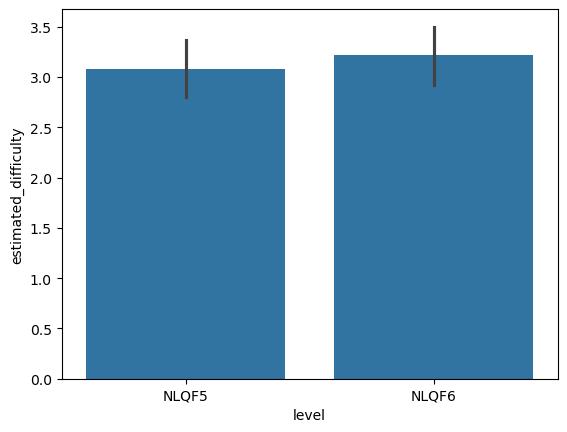

In [8]:
sns.barplot(x='level', y='estimated_difficulty', data=VKMDataWithoutNew)

Findings: De gemiddelde estimated difficulty bij level NLQF5 is ongeveer 3.1 en bij level NLQF6 is dat ongeveer 3.3, een erg klein verschil. De 95% betrouwbaarheidsintervallen van beide levels overlappen bijna volledig, wat betekent dat het verschil statistisch niet significant is.

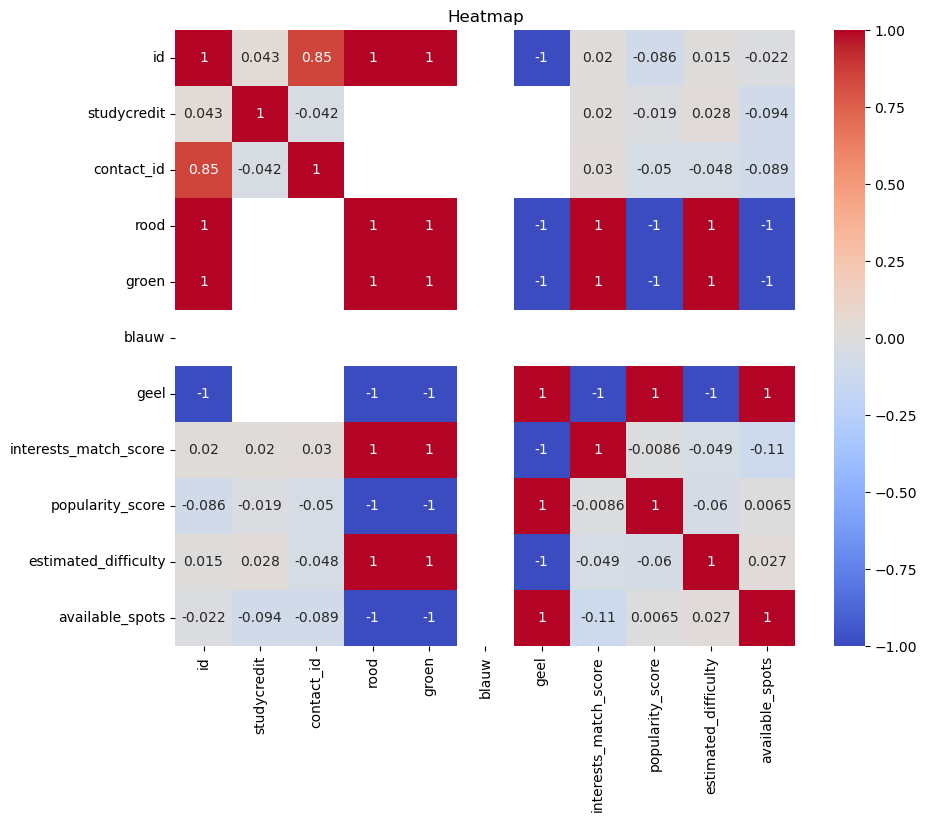

In [9]:
#Heatmap

numeric_cols = VKMDataWithoutNew.select_dtypes(include='number')

corr = numeric_cols.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heatmap")
plt.show()

Findings: Bij een correlation score van 0.7 of hoger / -0.7 of lager is er sprake van een sterke correlatie. De hoogste correlation score is tussen contact_id en id en dat is 0.86. Dat betekent dus dat daar een sterke correlatie tussen is, maar allebei die waarden hebben niet echt nut voor het suggesties geven van modules. Bij de rest van de waarden is er geen score hoger dan 0.7 of lager dan -0.7, dus is er voor de rest geen sterke correlatie. De sterkste correlatie na die tussen contact_id en id heeft een score van -0.11 wat heel erg laag is en er is dus ook niet een matige of zwakke correlatie bij een van de andere waarden.

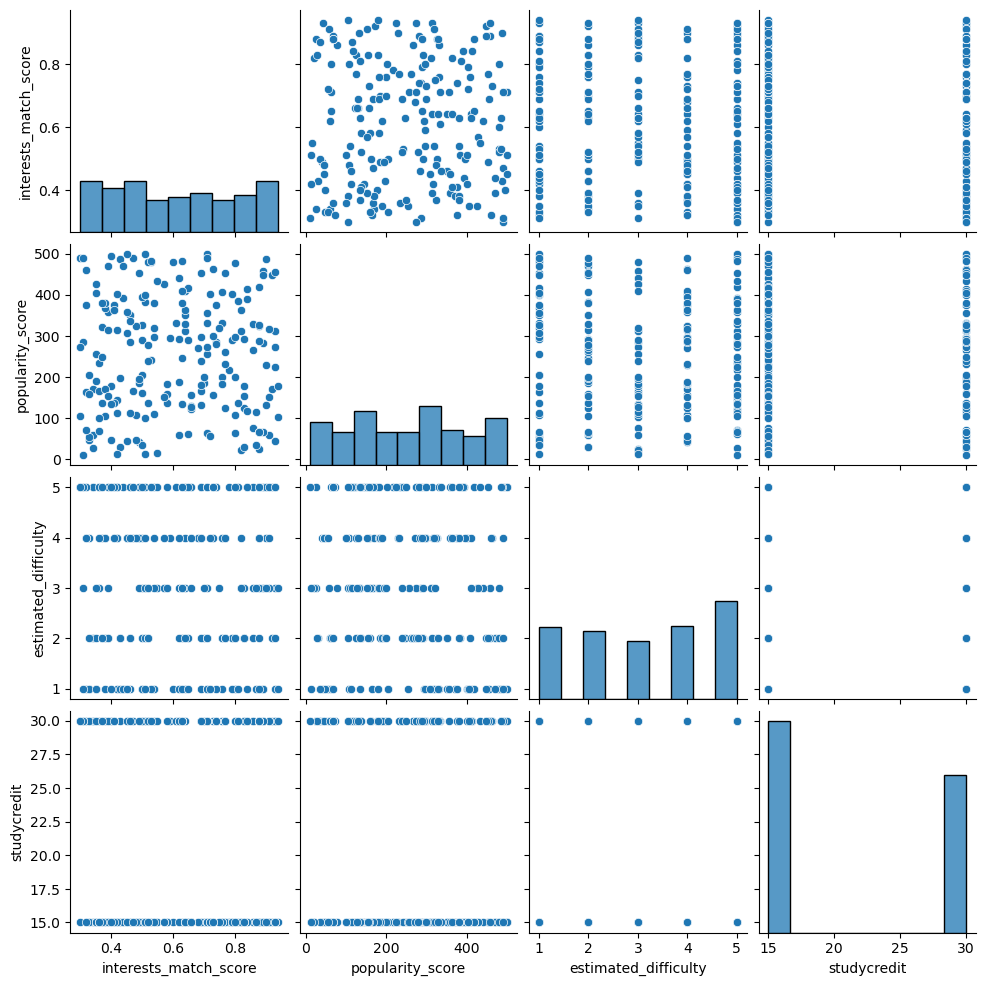

In [10]:
#Pairplot
sns.pairplot(VKMDataWithoutNew[['interests_match_score', 'popularity_score', 'estimated_difficulty', 'studycredit']])

Findings: Eigenlijk zijn er nergens echt correlaties te zien in de verschillende plots. Dit was ook wel te verwachten als je keek naar de heatmap, want daar bleek al uit dat er eigenlijk tussen geen van de waarden een sterke correlatie was naast contact_id en id.

In [11]:
# Laten vallen van onnodige dimensies en wat opschoning
VKMDataWithoutNew = VKMDataWithoutNew.drop(columns=[c for c in ['content','rood', 'groen', 'blauw','geel'] if c in VKMDataWithoutNew.columns])

# Vervang tekst 'Vraag aan de coordinator'
if 'studycredit' in VKMDataWithoutNew.columns:
    VKMDataWithoutNew['studycredit'] = VKMDataWithoutNew['studycredit'].replace(to_replace='Vraag aan de coordinator', value=np.nan)

# Handmatige invullingen. Obv de description. 
fill_short = {
    60: 'Nog niet bekend',
    106: 'Fatima en Grainne navragen',
    108: 'Navragen bij Lennard, Patricia en Hilde, Ben',
    139: 'Studenten leren operationele primaire bedrijfsprocessen te analyseren met kwalitatieve en kwantitatieve modellen.',
    140: 'Software- en infrastructuurinrichting van een organisatie beoordelen en advies te geven over de aanschaf van nieuwesoftware, inclusief de impact op processen, infrastructuur en bestaande systemen.',
    141: 'Nog niet bekend',
    142: 'De Engelstalige minor Aerospace Engineering & Maintenance (AE&I Breda) geeft studenten praktijkgerichte kennis over de snelgroeiende, internationaal georiënteerde luchtvaartsector.',
    143: 'you will be solving issues in a multidisciplinary team with the goal of making cities inclusive, smart, resilient and sustainable.',
    144: 'Het centrale thema van deze minor draait om technologische vernieuwing en innovatie binnen organisaties dat richt op het ontwikkelen en toepassen van nieuwe ideeën, producten, diensten en processen om bedrijfsvoering te verbeteren.',
    145: 'In deze minor leer je grootschalige softwaresystemen bouwen en testen met focus op kwaliteit binnen de hele SDLC. Je werkt met diverse testmethoden en tools om grip te krijgen op beheersbaarheid, kwaliteit en testen van complexe systemen.',
    147: 'In deze minor werk je met drie vormen van machine learning: supervised, unsupervised en reinforcement learning.',
    148: 'De minor Robotisering heeft als doel om studenten kennis en ervaring te laten opdoen met de ontwikkeling van robots.',
    152: 'Wil je met jouw onderzoek bijdragen aan een duurzamere toekomst en je onderzoeksskills verbeteren? Kies dan een onderzoeksproject binnen het Avans-zwaartepunt Transities in Energie en Materiaal.',
    153: 'AI wordt steeds belangrijker, maar brengt ook risico’s zoals privacyproblemen en discriminatie. Als AI-Vertaler leer je de brug slaan tussen techniek en maatschappij, zodat AI-oplossingen verantwoord, wenselijk en toepasbaar worden.',
    174: 'In deze module leer je over infectieziekten, microbiologie, immunologie, epidemiologie en hoe je infecties kunt voorkomen.',
    175: 'Bioinformatics combineert life science en informatica. Je werkt met data, programmeert, gebruikt Linux en diverse tools, en communiceert tussen biologen en programmeurs om biologische informatie zoals DNA, RNA en eiwitten te analyseren.',
    176: 'Je leert een katalytisch proces herkennen, meten en verbeteren op basis van experimentele data. Daarnaast reflecteer je op je rol binnen een team en gebruik je feedback om jezelf verder te ontwikkelen.',
    180: 'Om met proefdieren te werken, moet je als biomedisch onderzoeker voldoen aan de eisen voor biotechnicus volgens artikel 6 lid 1b van de Dierproevenregeling 2014.',
    188: 'Je leert hier om te werken met storytelling en het maken van animaties.',
    208: 'Je krijgt de kans om met creatieve ondernemers te sparren en te leren van hun praktijkervaring buiten het onderwijs.'
}
for idx, text in fill_short.items():
    if idx in VKMDataWithoutNew.index:
        VKMDataWithoutNew.loc[idx, 'shortdescription'] = text

# Invullen module_tags obv description
if 208 in VKMDataWithoutNew.index:
    VKMDataWithoutNew.loc[208, 'module_tags'] = "['persoonlijke', 'ontwikkeling', 'interdisciplinair', 'innovatie', 'prototyping', 'valorisatie', 'ondernemerschap', 'samenwerking', 'praktijkervaring', 'creativiteit']"

# invullen van learningoutcomes
lo_fill = {
    210: "De student herkent en analyseert ethische dilemma’s in de beroepspraktijk, reflecteert op eigen normen en waarden en past zijn moreel kompas toe om integer en verantwoord te handelen binnen complexe organisaties en maatschappelijke contexten.",
    71: "De student ontwerpt en onderbouwt duurzame oplossingen voor actuele vraagstukken binnen de gebouwde omgeving, rekening houdend met maatschappelijke transities zoals klimaatverandering, energietransitie en watermanagement.",
    84: "The student analyzes and evaluates migration-related crises and their societal impact, and develops policy-oriented, ethical, and resilient strategies for crisis response and risk management in an international context.",
    158: "De student past kennis van medicinale, organische, bioanalytische en data-chemie toe om de relatie tussen chemische processen, voeding en gezondheid te onderzoeken en oplossingen te ontwikkelen voor toepassingen binnen de gezondheidssector.",
    164: "De student onderzoekt en analyseert chemische processen in voeding en medicijnen, en gebruikt kennis van medicinale, organische, bioanalytische en data-chemie om toepassingen voor gezondheid en welzijn te ontwikkelen.",
    195: "De student begeleidt effectief veranderingsprocessen binnen organisaties, begrijpt psychologische en groepsdynamische processen, en past methoden zoals Appreciative Inquiry toe om mensen te verbinden en gezamenlijk organisatiedoelen te bereiken."
}
for idx, text in lo_fill.items():
    if idx in VKMDataWithoutNew.index:
        VKMDataWithoutNew.loc[idx, 'learningoutcomes'] = text

# Drop modules die je niet nodig hebt
to_drop = [i for i in [106, 108, 139, 141] if i in VKMDataWithoutNew.index]
if to_drop:
    VKMDataWithoutNew = VKMDataWithoutNew.drop(to_drop)

# Zorg dat indexen daarna 0..n-1 voor eenvoud
VKMDataWithoutNew = VKMDataWithoutNew.reset_index(drop=True)

print('Na opschoning shape:', VKMDataWithoutNew.shape)


Na opschoning shape: (207, 15)


In [12]:
# voor elke veld kan mogelijk deze kolom erbij horen
ALIASES: Dict[str, List[str]] = {
    "module_id": ["id", "module_id", "course_id", "moduleId", "identificatie", "nummer"],
    "title": ["name", "title", "module_name", "naam", "course_title"],
    "short_description": ["shortdescription", "short_description", "samenvatting", "kort_omschrijving", "kortomschrijving"],
    "description": ["description", "omschrijving", "module_description", "job_description", "vacaturetekst"],
    "content": ["content", "inhoud", "volle_tekst", "full_text"],
    "study_credit": ["studycredit", "study_credit", "credits", "ec", "sp", "studiepunten"],
    "location": ["location", "locatie", "standplaats", "city"],
    "contact_id": ["contact_id", "contact", "contactpersoon"],
    "level": ["level", "niveau", "nlqf", "level_code"],
    "learning_outcomes": ["learningoutcomes", "learning_outcomes", "leerdoelen", "learning_outcome"],
    "color_red": ["rood", "red", "score_rood"],
    "color_green": ["groen", "green", "score_groen"],
    "color_blue": ["blauw", "blue", "score_blauw"],
    "color_yellow": ["geel", "yellow", "score_geel"],
    "module_tags": ["module_tags", "tags", "module_tag", "categorie", "categorieen", "interests", "module_topics"],
    "interests_match_score": ["interests_match_score", "interests_match", "interests_matchscore"],
    "popularity_score": ["popularity_score", "popularity", "populariteit", "num_applicants"],
    "estimated_difficulty": ["estimated_difficulty", "difficulty", "moeilijkheidsgraad", "estimateddifficulty"],
    "available_spots": ["available_spots", "spots", "aantal_plaatsen", "beschikbare_plekken"],
    "start_date": ["start_date", "startdatum", "begin_datum", "start"],
}

def pick_col(VKMDataWithoutNew: pd.DataFrame, aliases: List[str]) -> Optional[str]:
    cols = list(VKMDataWithoutNew.columns)
    for alias in aliases: # voor elke logische veld horen mogelijk die kolomnamen
        alias_norm = norm_col(alias)
        for c in cols:
            if norm_col(c) == alias_norm: #loopt alles 
                return c
    return None
#  maakt alles 1
COLS: Dict[str, Optional[str]] = {key: pick_col(VKMDataWithoutNew, aliases) for key, aliases in ALIASES.items()}
COLS


{'module_id': 'id',
 'title': 'name',
 'short_description': 'shortdescription',
 'description': 'description',
 'content': None,
 'study_credit': 'studycredit',
 'location': 'location',
 'contact_id': 'contact_id',
 'level': 'level',
 'learning_outcomes': 'learningoutcomes',
 'color_red': None,
 'color_green': None,
 'color_blue': None,
 'color_yellow': None,
 'module_tags': 'module_tags',
 'interests_match_score': 'interests_match_score',
 'popularity_score': 'popularity_score',
 'estimated_difficulty': 'estimated_difficulty',
 'available_spots': 'available_spots',
 'start_date': 'start_date'}

In [13]:
# Maak module_text van relevante tekstkolommen
text_parts = []
for key in ["short_description", "description", "learning_outcomes", "module_tags", "location", "study_credit"]:
    col = COLS.get(key)
    if col and col in VKMDataWithoutNew.columns:
        text_parts.append(VKMDataWithoutNew[col].fillna("").astype(str))
# fout als er geen tekstkolom zijn met duidelijke foutmelding
if not text_parts:
    raise ValueError("Geen geschikte tekstkolommen gevonden om 'module_text' te maken. Controleer je data.")
# alle teksten aan elkaar vast plakken
module_text = text_parts[0]
for part in text_parts[1:]:
    module_text = module_text + " " + part
# opschonen en schrijven naar module text
VKMDataWithoutNew["module_text"] = module_text.str.replace(r"\s+", " ", regex=True).str.strip()
display(VKMDataWithoutNew[[COLS.get('title') or VKMDataWithoutNew.columns[0], 'module_text']].head())


,name,module_text
0,Kennismaking met Psychologie,"Brein, gedragsbeinvloeding, ontwikkelingspsychologie, gespreksvoering en ontwikkelingsfasen. In deze module leer je hoe je gedrag van jezelf en van anderen kunt begrijpen en beinvloeden. Je maakt ..."
1,Learning and working abroad,"Internationaal, persoonlijke ontwikkeling, verpleegkunde Studenten kiezen binnen de (stam) van de opleiding van Verpleegkunde steeds vaker voor een stage in het buitenland, waarbij zij de beroepsp..."
2,Proactieve zorgplanning,"Proactieve zorgplanning, cocreatie, ziekenhuis Het Jeroen Bosch ziekenhuis wil graag samen met de opleiding Verpleegkunde een module ontwikkelen, waarin de studenten de mogelijkheid krijgen om zic..."
3,Rouw en verlies,"Rouw & verlies, palliatieve zorg & redeneren, trauma, culturele diversiteit In deze module wordt stil gestaan bij rouw en verlies, vanuit diverse invalshoeken waaronder de palliatieve zorg. Thema'..."
4,Acuut complexe zorg,"Acute zorg, complexiteit, ziekenhuis, revalidatie In deze module kunnen studenten zich verdiepen in de acuut, complexe zorg binnen het verpleegkundig vakgebied. De student regisseert en voert (dee..."


In [29]:
# we gaan gebruik maken van stopwords. Die weinig betekenis hebben voor inhoudelijke overeenkomsten.
dutch_stop = stopwords.words("dutch")

tfidf = TfidfVectorizer(
    max_features=80000, # beperkt worden tot 8k)
    ngram_range=(1, 2), # 1 woord en woordparen zijn toegestaan. (ai, big data)
    stop_words=dutch_stop # gooit alle common nederlandse woorden weg
)

tfidf2 = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 1),
    stop_words=dutch_stop
)


# neemt module tekst. alles wat geen module tekst heeft wordt nan
# leert het vocubulair en welke termen vaak komen
# zet alles om in een vector met scores
X = tfidf.fit_transform(VKMDataWithoutNew["module_text"].fillna(""))
X2 = tfidf2.fit_transform(VKMDataWithoutNew["module_text"].fillna(""))
# geef rij terug en de kolom met features 
# cosine similarity berekenen en zo dan ook aanbevelingen te genereren.
X.shape
X2.shape

(207, 3986)

In [15]:
# maakt een soort slimme container met een proef profile.
@dataclass
class CandidateProfile:
    interests_text: str = "Ik hou om te ondernemen. Ik kan goed werken met excel en word. Het liefste doe ik later iets op kantoor achter de computer. Ik hou er ook van om met mensen te werken"
    preferred_location: Optional[str] = ""
    moduletags_include: Optional[List[str]] = ""
# hier trandfort hij het in dezelfde TF-IDF ruimte. en berekent alles ook voor de candidate profile
def profile_vector(profile: CandidateProfile):
    return tfidf.transform([profile.interests_text])


In [16]:
#  alles wordt een string en vervang alle komma;s door punten. 
# pakt alle nummers en zet dit om naar float en return deze waarde
def extract_numeric_series(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.replace(",", ".", regex=False)
    nums = pd.to_numeric(
        s.str.extract(r"([0-9]+\.?[0-9]*)")[0],
        errors="coerce"
    )
    return nums

# Definieer constraint-gewichten
W_LOCATION = 0.4
W_TAGS = 0.3

def constraint_score(row: pd.Series, profile: CandidateProfile) -> Tuple[float, Dict[str, str]]:

    scores: List[float] = []
    weights: List[float] = []
    reasons: Dict[str, str] = {}

    # Location check
    if getattr(profile, 'preferred_location', None) and 'location' in row.index:
        job_loc = str(row['location']).lower()
        pref = str(profile.preferred_location).lower()
        match = pref in job_loc
        scores.append(1.0 if match else 0.0)
        weights.append(W_LOCATION)
        reasons['location'] = f"Location {'matches' if match else 'does not match'}: candidate={profile.preferred_location}, module={row['location']}"
    else:
        reasons['location'] = "No location preference or no 'location' column."

    # Module tags / domain match
    wanted = getattr(profile, 'moduletags_include', None)
    if wanted and 'module_tags' in row.index:
        tags = str(row['module_tags']).lower()
        wanted_list = [w.lower() for w in wanted]
        match_count = sum(1 for w in wanted_list if w in tags)
        sc = min(1.0, match_count / max(1, len(wanted_list)))
        scores.append(float(sc))
        weights.append(W_TAGS)
        reasons['module_tags'] = f"Tag match: found {match_count} of {len(wanted_list)} wanted tags"
    else:
        reasons['module_tags'] = "No wanted tags provided or no 'module_tags' column."

    if not scores:
        return 0.0, reasons

    total_w = sum(weights) if sum(weights) > 0 else 1.0
    weighted_score = float(sum(s * w for s, w in zip(scores, weights)) / total_w)
    return weighted_score, reasons


In [17]:
def first_existing_col(df: pd.DataFrame, candidates: list) -> Optional[str]:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def recommend(
    profile: CandidateProfile,
    VKM_df: pd.DataFrame,
    tfidf_vectorizer,
    X_matrix,
    k: int = 10,
    alpha: float = 0.7,
    beta: float = 0.2,
    gamma: float = 0.1
) -> pd.DataFrame:
    """Returneert top-k aanbevelingen als DataFrame.
    Let op: alpha + beta + gamma moeten ongeveer 1.0 zijn.
    """
    if not np.isclose(alpha + beta + gamma, 1.0):
        raise ValueError('alpha + beta + gamma must sum to 1.0')

    # Reset index voor positionele alignement met content scores
    df = VKM_df.reset_index(drop=True)

    # Content similarity
    p_vec = tfidf_vectorizer.transform([profile.interests_text])
    content_scores = cosine_similarity(p_vec, X_matrix).flatten()

    # Popularity score (0..1)
    if 'popularity_score' in df.columns:
        pop_raw = extract_numeric_series(df['popularity_score']).fillna(0.0)
        pop_scaled = (pop_raw - pop_raw.min()) / (pop_raw.max() - pop_raw.min() + 1e-9)
        pop_scaled = pop_scaled.reset_index(drop=True)
    else:
        pop_scaled = pd.Series(0.0, index=df.index)

    rows = []
    title_col = 'name' if 'name' in df.columns else df.columns[0]
    loc_col = 'location' if 'location' in df.columns else None

    for pos, row in df.iterrows():
        cstr_score, reasons = constraint_score(row, profile)
        c_score = float(content_scores[pos])
        pop_score = float(pop_scaled.loc[pos]) if pos in pop_scaled.index else 0.0

        final_score = alpha * c_score + beta * cstr_score + gamma * pop_score

        rows.append({
            'pos': pos,
            'name': row.get(title_col, ''),
            'location': row.get(loc_col, ''),
            'final_score': final_score,
            'content_sim': c_score,
            'constraint_score': cstr_score,
            'popularity_score': pop_score,
            'constraint_reasons': reasons,
        })

    rec_df = pd.DataFrame(rows).sort_values('final_score', ascending=False).head(k).reset_index(drop=True)
    return rec_df


In [18]:
def diversity_score(indices: List[int]) -> float:
    if len(indices) < 2:
        return 0.0
    sub = X[indices]
    sim = cosine_similarity(sub)
    mask = np.triu(np.ones_like(sim, dtype=bool), k=1)
    if mask.sum() == 0:
        return 0.0
    avg_sim = sim[mask].mean()
    return float(1.0 - avg_sim)

def explain_overlap(profile_text: str, job_text: str, top_k: int = 8) -> List[str]:
    def tokenize(s: str) -> List[str]:
        return re.findall(r"\w+", s.lower())

    p_tokens = tokenize(profile_text)
    j_tokens = tokenize(job_text)
    common = [t for t in j_tokens if t in set(p_tokens)]
    counts: Dict[str, int] = {}
    for t in common:
        counts[t] = counts.get(t, 0) + 1
    sorted_terms = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    return [w for w, _ in sorted_terms[:top_k]]


In [19]:
# Run recommendation demo
print('Calculating recommendations...')
profile = CandidateProfile()  # instantie, niet de klasse
demo_recs = recommend(profile, VKMDataWithoutNew, tfidf, X, k=5, alpha=0.7, beta=0.2, gamma=0.1)
display(demo_recs)
# Voor extra uitleg: overlap voor de eerste aanbevolen module
if not demo_recs.empty:
    first_idx = int(demo_recs.loc[0, 'pos'])
    overlap = explain_overlap(profile.interests_text, VKMDataWithoutNew.loc[first_idx, 'module_text'])
    print('\nTop overlapping terms:', overlap)


Calculating recommendations...


,pos,name,location,final_score,content_sim,constraint_score,popularity_score,constraint_reasons
0,14,Langer thuis in de wijk,Breda,0.127548,0.068218,0.0,0.797959,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
1,191,Veranderen is Mensenwerk,Den Bosch,0.118469,0.031341,0.0,0.965306,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
2,78,Module 3.4 Duurzaam gebouwde omgeving - Veilige veerkrachtige stad,Den Bosch en Tilburg,0.115954,0.028622,0.0,0.959184,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
3,80,Module 4.1/4.1Toekomstbestendig ondernemerschap in de gebouwde omgeving (nieuwe minor),Tilburg,0.114965,0.089892,0.0,0.520408,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
4,76,Module 3.4 Duurzaam gebouwde omgeving - Energietransitie in de praktijk,Den Bosch en Tilburg,0.114783,0.027533,0.0,0.955102,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"



Top overlapping terms: ['en', 'werken', 'mensen', 'met', 'te', 'van', 'de', 'ook']


In [30]:
# Run recommendation demo met andere tfidf
print('Calculating recommendations...')
profile = CandidateProfile()  # instantie, niet de klasse
demo_recs = recommend(profile, VKMDataWithoutNew, tfidf2, X2, k=5, alpha=0.7, beta=0.2, gamma=0.1)
display(demo_recs)
# Voor extra uitleg: overlap voor de eerste aanbevolen module
if not demo_recs.empty:
    first_idx = int(demo_recs.loc[0, 'pos'])
    overlap = explain_overlap(profile.interests_text, VKMDataWithoutNew.loc[first_idx, 'module_text'])
    print('\nTop overlapping terms:', overlap)


Calculating recommendations...


,pos,name,location,final_score,content_sim,constraint_score,popularity_score,constraint_reasons
0,14,Langer thuis in de wijk,Breda,0.153500,0.105291,0.0,0.797959,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
1,80,Module 4.1/4.1Toekomstbestendig ondernemerschap in de gebouwde omgeving (nieuwe minor),Tilburg,0.148197,0.137365,0.0,0.520408,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
2,191,Veranderen is Mensenwerk,Den Bosch,0.128349,0.045455,0.0,0.965306,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
3,78,Module 3.4 Duurzaam gebouwde omgeving - Veilige veerkrachtige stad,Den Bosch en Tilburg,0.127468,0.045072,0.0,0.959184,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
4,76,Module 3.4 Duurzaam gebouwde omgeving - Energietransitie in de praktijk,Den Bosch en Tilburg,0.126193,0.043832,0.0,0.955102,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"



Top overlapping terms: ['en', 'werken', 'mensen', 'met', 'te', 'van', 'de', 'ook']


In [20]:
# Run recommendation demo 2
print('Calculating recommendations...')
profile2 = CandidateProfile(
    interests_text="Ik ben geïnteresseerd in data-analyse, Python, statistiek en machine learning.",
    preferred_location="",
    moduletags_include="")  # instantie, niet de klasse
demo_recs = recommend(profile2, VKMDataWithoutNew, tfidf, X, k=5, alpha=0.7, beta=0.2, gamma=0.1)
display(demo_recs)
# Voor extra uitleg: overlap voor de eerste aanbevolen module
if not demo_recs.empty:
    first_idx = int(demo_recs.loc[0, 'pos'])
    overlap = explain_overlap(profile2.interests_text, VKMDataWithoutNew.loc[first_idx, 'module_text'])
    print('\nTop overlapping terms:', overlap)

Calculating recommendations...


,pos,name,location,final_score,content_sim,constraint_score,popularity_score,constraint_reasons
0,167,Molecular Modeling & Data-driven Analysis,Breda,0.287809,0.271506,0.0,0.977551,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
1,128,Datagedreven besluitvorming met AI,Breda,0.229951,0.287393,0.0,0.287755,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
2,117,Toekomstgerichte productielijn,Den Bosch,0.162252,0.113130,0.0,0.830612,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
3,142,Smart Industry & Internet of Things,Breda,0.148791,0.157456,0.0,0.385714,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
4,143,Artifical Intelligence,Breda,0.146805,0.173569,0.0,0.253061,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"



Top overlapping terms: ['en', 'data', 'python', 'machine', 'learning', 'analyse', 'in']


In [31]:
# Run recommendation demo 2 met andere tfidf
print('Calculating recommendations...')
profile2 = CandidateProfile(
    interests_text="Ik ben geïnteresseerd in data-analyse, Python, statistiek en machine learning.",
    preferred_location="",
    moduletags_include="")  # instantie, niet de klasse
demo_recs = recommend(profile2, VKMDataWithoutNew, tfidf2, X2, k=5, alpha=0.7, beta=0.2, gamma=0.1)
display(demo_recs)
# Voor extra uitleg: overlap voor de eerste aanbevolen module
if not demo_recs.empty:
    first_idx = int(demo_recs.loc[0, 'pos'])
    overlap = explain_overlap(profile2.interests_text, VKMDataWithoutNew.loc[first_idx, 'module_text'])
    print('\nTop overlapping terms:', overlap)

Calculating recommendations...


,pos,name,location,final_score,content_sim,constraint_score,popularity_score,constraint_reasons
0,128,Datagedreven besluitvorming met AI,Breda,0.348614,0.456912,0.0,0.287755,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
1,167,Molecular Modeling & Data-driven Analysis,Breda,0.331381,0.333751,0.0,0.977551,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
2,117,Toekomstgerichte productielijn,Den Bosch,0.208202,0.178773,0.0,0.830612,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
3,143,Artifical Intelligence,Breda,0.198599,0.247561,0.0,0.253061,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
4,163,Forensische Chemie,Breda en Den Bosch,0.177344,0.223611,0.0,0.208163,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"



Top overlapping terms: ['data', 'en', 'python', 'in', 'analyse']


In [25]:
# Run recommendation demo 3
print('Calculating recommendations...')
profile3 = CandidateProfile(
    interests_text="Ik ben verpleegkundestudent en geïnteresseerd in verpleegkundige zorg, klinisch redeneren en patiëntcommunicatie. Ik wil ervaring opdoen in ziekenhuis- en thuiszorgomgevingen.",
    preferred_location="",
    moduletags_include="")  # instantie, niet de klasse
demo_recs = recommend(profile3, VKMDataWithoutNew, tfidf, X, k=5, alpha=0.7, beta=0.2, gamma=0.1)
display(demo_recs)
# Voor extra uitleg: overlap voor de eerste aanbevolen module
if not demo_recs.empty:
    first_idx = int(demo_recs.loc[0, 'pos'])
    overlap = explain_overlap(profile3.interests_text, VKMDataWithoutNew.loc[first_idx, 'module_text'])
    print('\nTop overlapping terms:', overlap)

Calculating recommendations...


,pos,name,location,final_score,content_sim,constraint_score,popularity_score,constraint_reasons
0,42,Positieve psychiatrie,Breda,0.209375,0.192401,0.0,0.746939,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
1,4,Acuut complexe zorg,Den Bosch,0.176225,0.202770,0.0,0.342857,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
2,5,Kraam kind en jeugd,Den Bosch,0.170681,0.103014,0.0,0.985714,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
3,2,Proactieve zorgplanning,Den Bosch,0.135457,0.133160,0.0,0.422449,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
4,3,Rouw en verlies,Den Bosch,0.129586,0.055677,0.0,0.906122,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"



Top overlapping terms: ['zorg', 'en', 'verpleegkundige', 'in', 'klinisch', 'redeneren']


In [27]:
tfidf2 = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 1),
    stop_words=dutch_stop
)
X2 = tfidf2.fit_transform(VKMDataWithoutNew["module_text"].fillna(""))
X2.shape

(207, 3986)

In [28]:
# Run recommendation demo 3 met andere tfidf
print('Calculating recommendations...')
profile3 = CandidateProfile(
    interests_text="Ik ben verpleegkundestudent en geïnteresseerd in verpleegkundige zorg, klinisch redeneren en patiëntcommunicatie. Ik wil ervaring opdoen in ziekenhuis- en thuiszorgomgevingen.",
    preferred_location="",
    moduletags_include="")  # instantie, niet de klasse
demo_recs = recommend(profile3, VKMDataWithoutNew, tfidf2, X2, k=5, alpha=0.7, beta=0.2, gamma=0.1)
display(demo_recs)
# Voor extra uitleg: overlap voor de eerste aanbevolen module
if not demo_recs.empty:
    first_idx = int(demo_recs.loc[0, 'pos'])
    overlap = explain_overlap(profile3.interests_text, VKMDataWithoutNew.loc[first_idx, 'module_text'])
    print('\nTop overlapping terms:', overlap)

Calculating recommendations...


,pos,name,location,final_score,content_sim,constraint_score,popularity_score,constraint_reasons
0,4,Acuut complexe zorg,Den Bosch,0.268913,0.335182,0.0,0.342857,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
1,42,Positieve psychiatrie,Breda,0.228715,0.220031,0.0,0.746939,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
2,144,Robotisering,Breda,0.201541,0.244476,0.0,0.304082,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
3,5,Kraam kind en jeugd,Den Bosch,0.197736,0.141664,0.0,0.985714,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"
4,2,Proactieve zorgplanning,Den Bosch,0.185633,0.204840,0.0,0.422449,"{'location': 'No location preference or no 'location' column.', 'module_tags': 'No wanted tags provided or no 'module_tags' column.'}"



Top overlapping terms: ['en', 'in', 'zorg', 'ziekenhuis', 'verpleegkundige', 'klinisch', 'redeneren']


Bij alle profielen behaalt het model hogere final_scores en content_sims als het de tfidf gebruikt met max_features=20000 en een ngram_range heeft van (1, 1). Daarom hebben we gekozen om die tfidf te gebruiken.